### Load libraries

In [1]:

import sys
sys.path.insert(0, '../scripts/')

from load_modify_sample_utils import load_model, get_objective_functions, modify_model, get_reaction_bounds
from load_modify_sample_utils import sample_dingo, sample_optgp, plot_grid_95_reactions, sampling_statistics

/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/touliopoulos/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Load a model

In [2]:

ec_cobra_model, ec_cobra_reactions, ec_dingo_model, ec_dingo_reactions = load_model("../ext_data/models/e_coli_core.xml")

default_objective_functions = get_objective_functions(ec_cobra_model)
print(default_objective_functions)

default_reaction_bounds = get_reaction_bounds(ec_cobra_model)
print(default_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))



Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
['BIOMASS_Ecoli_core_w_GAM']
(0.0, 1000.0)


### Perform FBA on the initial model

In [3]:

solution = ec_cobra_model.optimize()
print(solution.objective_value)


0.8739215069684302


### Modify a model

In [3]:

# Set optimal percentage to 100

ec_cobra_model_condition_1, ec_dingo_model_condition_1 = modify_model(ec_cobra_model, 
                                                                      objective_function="BIOMASS_Ecoli_core_w_GAM", 
                                                                      optimal_percentage=100,
                                                                      objective_direction="max")

updated_objective_functions = get_objective_functions(ec_cobra_model_condition_1)
print(updated_objective_functions)

updated_reaction_bounds = get_reaction_bounds(ec_cobra_model_condition_1)
print(updated_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))

# -----------

# Set optimal percentage to 0

ec_cobra_model_condition_2, ec_dingo_model_condition_2 = modify_model(ec_cobra_model,
                                                                      objective_function="BIOMASS_Ecoli_core_w_GAM",
                                                                      optimal_percentage=0,
                                                                      objective_direction="max")

updated_objective_functions = get_objective_functions(ec_cobra_model_condition_2)
print(updated_objective_functions)

updated_reaction_bounds = get_reaction_bounds(ec_cobra_model_condition_2)
print(updated_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))


Read LP format model from file /tmp/tmpeh8xuwq9.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


['BIOMASS_Ecoli_core_w_GAM']
(0.872922, 1000)
Read LP format model from file /tmp/tmpx77v_skt.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
['BIOMASS_Ecoli_core_w_GAM']
(0.0, 1000)


### Peform FBA on the modified models

In [5]:

solution_1 = ec_cobra_model_condition_1.optimize()
print(solution_1.objective_value)


solution_2 = ec_cobra_model_condition_2.optimize()
print(solution_2.objective_value)


0.8739215069684301
0.8739215069684301


### Sample with the modified models

In [4]:

samples_dingo_condition_1 = sample_dingo(ec_dingo_model_condition_1, reaction_in_rows = True, ess=3000, solver="gurobi", final_n_samples=2000)
samples_dingo_condition_2 = sample_dingo(ec_dingo_model_condition_2, reaction_in_rows = True, ess=3000, solver="gurobi", final_n_samples=2000)


samples_optgp_condition_1 = sample_optgp(ec_cobra_model_condition_1, n_samples = 3000, thinning=100, reaction_in_rows = True)
samples_optgp_condition_2 = sample_optgp(ec_cobra_model_condition_2, n_samples = 3000, thinning=100, reaction_in_rows = True)


Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
phase 1: number of correlated samples = 500, effective sample size = 4, ratio of the maximum singilar value over the minimum singular value = 1724.72
phase 2: number of correlated samples = 500, effective sample size = 14, ratio of the maximum singilar value over the minimum singular value = 179.015
phase 3: number of correlated samples = 500, effective sample size = 7, ratio of the maximum singilar value over the minimum singular value = 355.901
phase 4: number of correlated samples = 500, effective sample size = 145, ratio of the maximum singilar value over the minimum singular value = 19.2745
phase 5: number of correlated samples = 500, effective sample size = 177, ratio of the maximum singilar value over the minimum singular value = 3.22522
phase 6: number of correlated samples = 500, effective sample size = 128, ratio of the maximum singilar value ove

[5]maximum marginal PSRF: 1.05473


phase 1: number of correlated samples = 500, effective sample size = 9, ratio of the maximum singilar value over the minimum singular value = 2074.16
phase 2: number of correlated samples = 500, effective sample size = 25, ratio of the maximum singilar value over the minimum singular value = 81.8733
phase 3: number of correlated samples = 500, effective sample size = 4, ratio of the maximum singilar value over the minimum singular value = 241.543
phase 4: number of correlated samples = 500, effective sample size = 111, ratio of the maximum singilar value over the minimum singular value = 49.676
phase 5: number of correlated samples = 500, effective sample size = 173, ratio of the maximum singilar value over the minimum singular value = 2.74573
phase 6: number of correlated samples = 2400, effective sample size = 1056
phase 7: number of correlated samples = 2400, effective sample size = 1093
phase 8: number of correlated samples = 2200, effective sample size = 1008
[5]total ess 3479: nu

[5]maximum marginal PSRF: 1.00685


Read LP format model from file /tmp/tmpbap9rhol.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


### Plot grid of the distributions

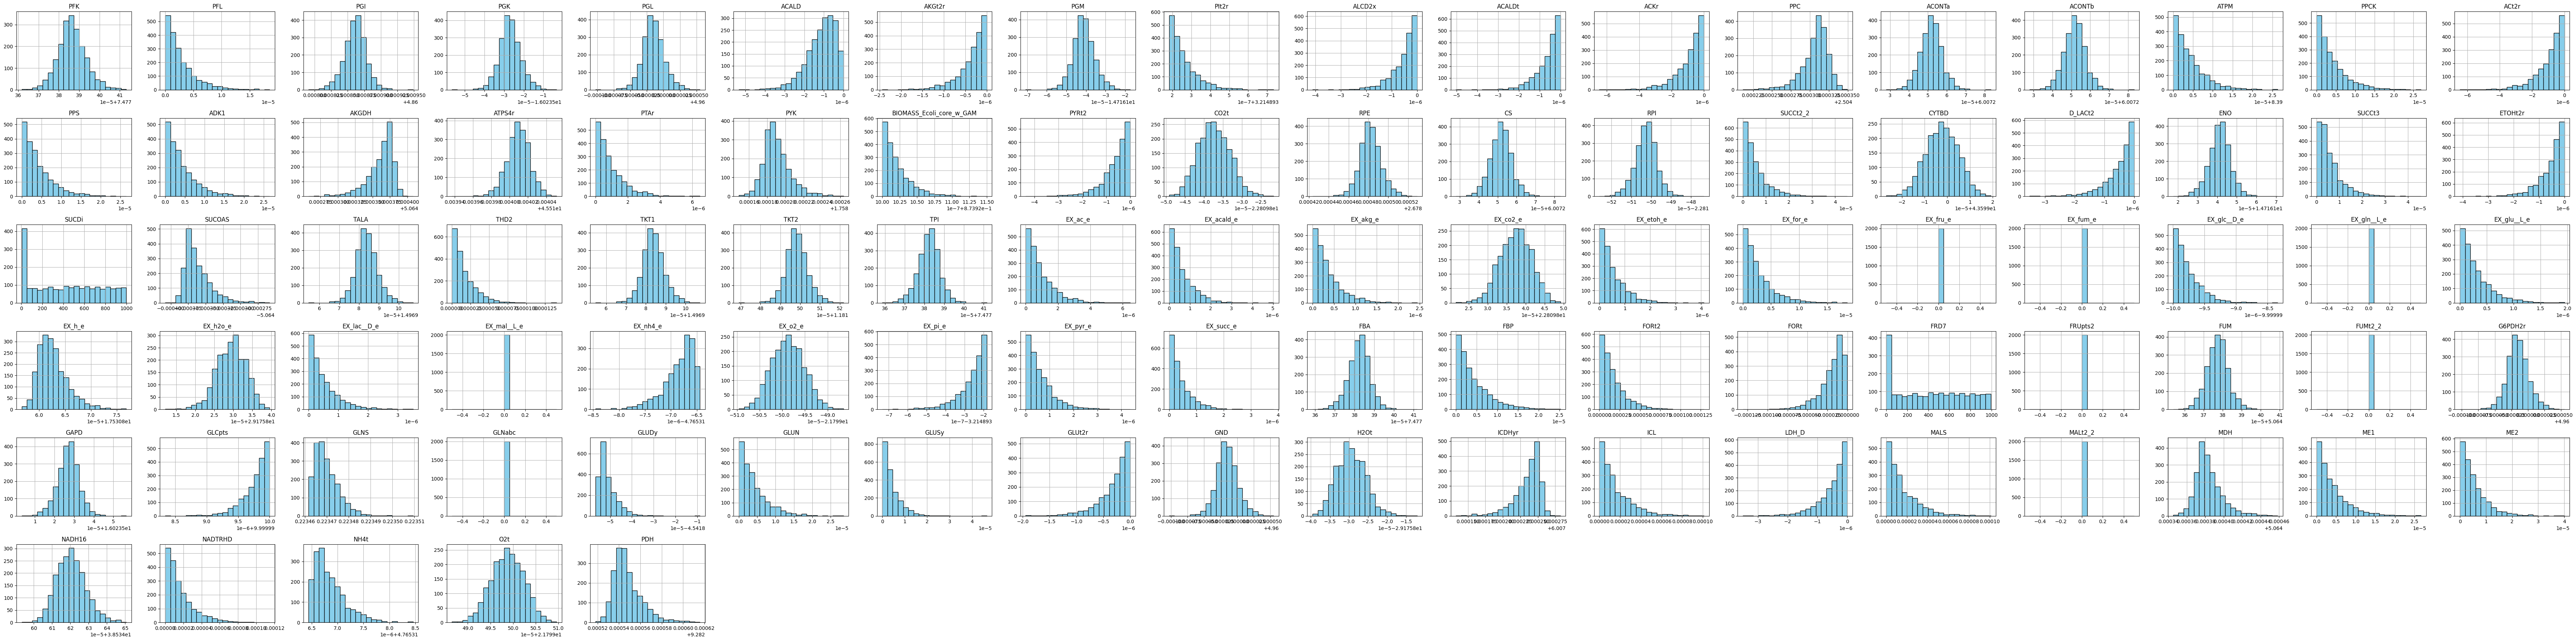

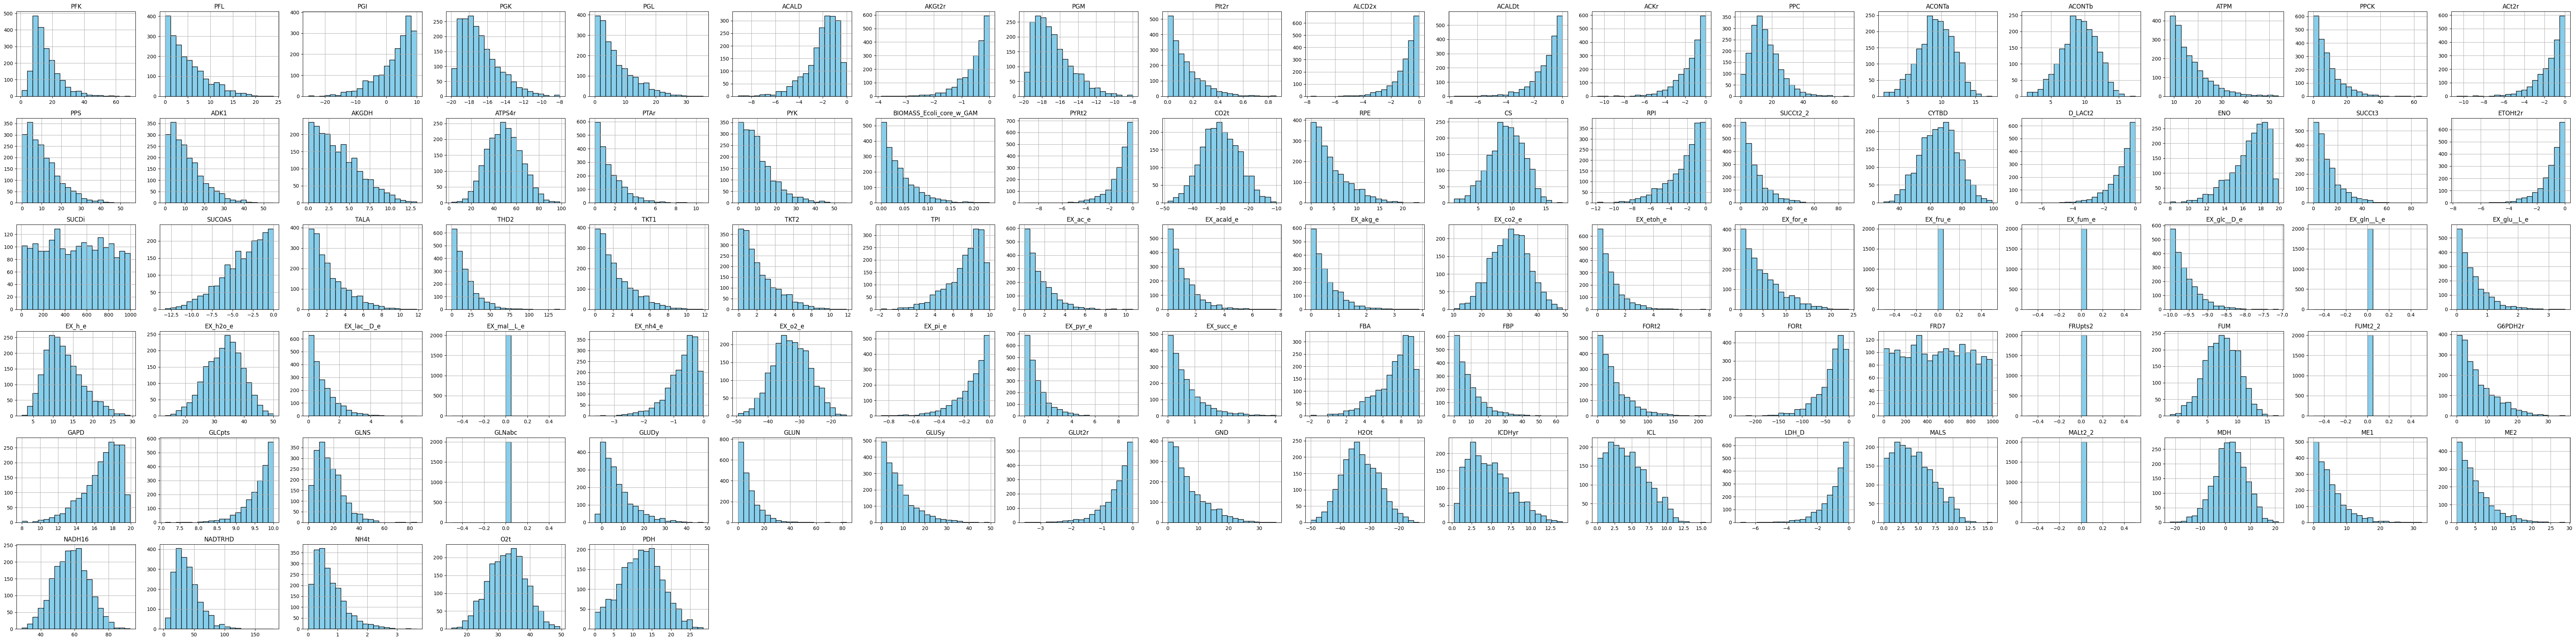

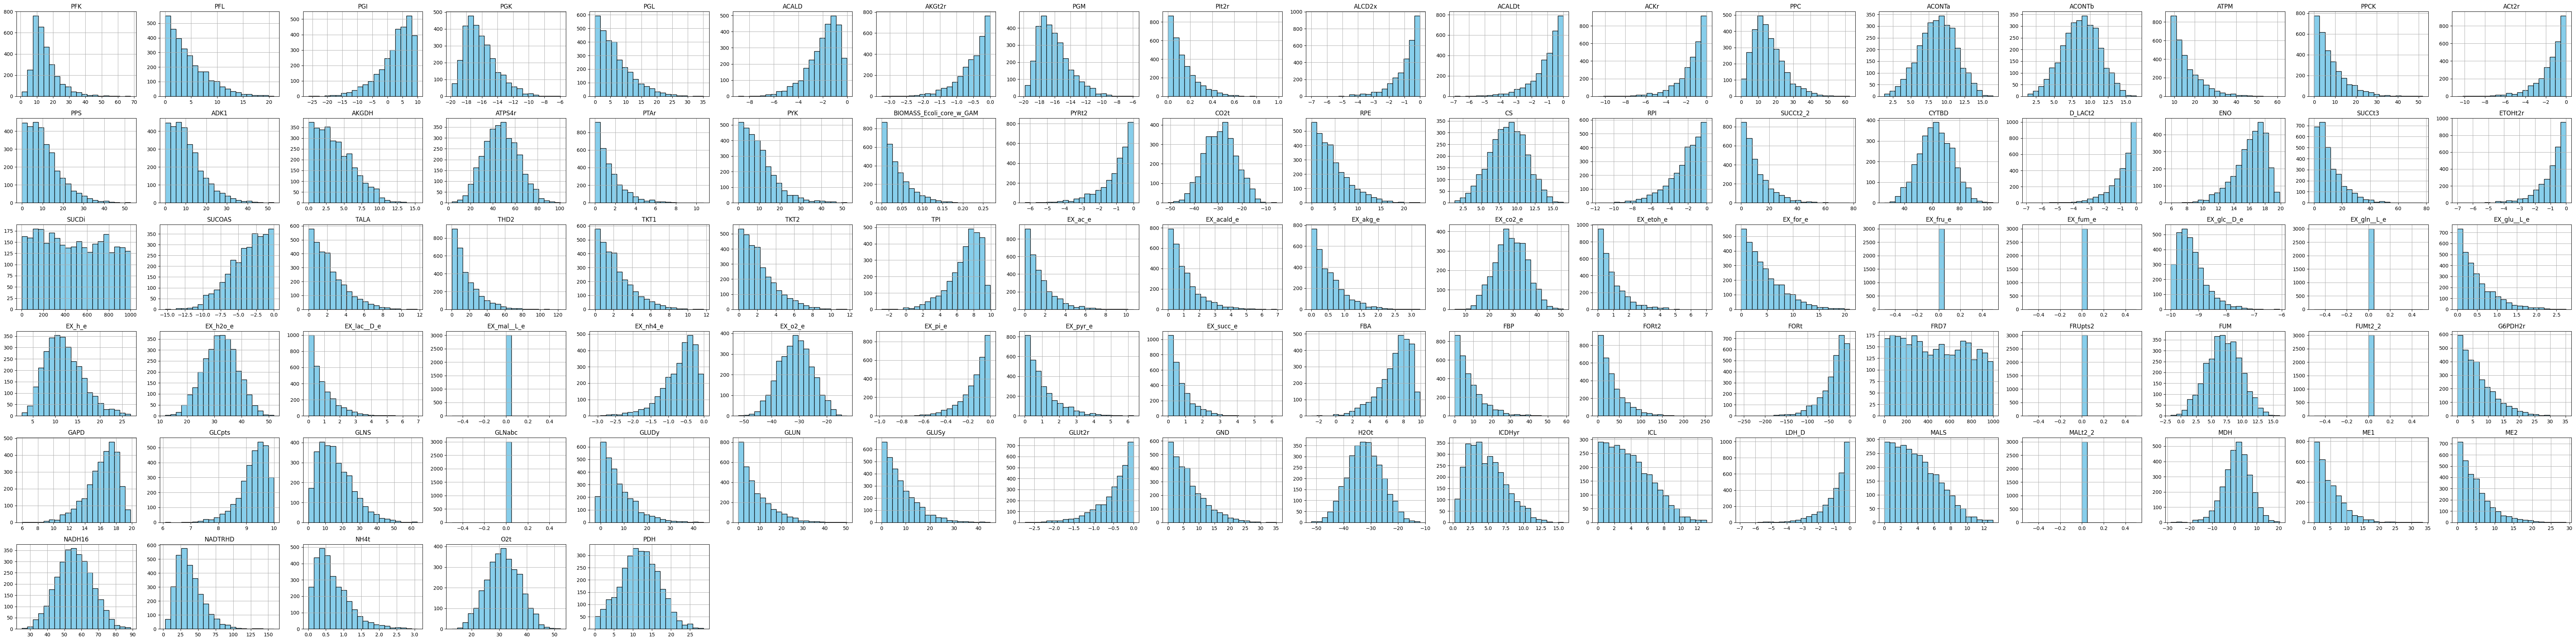

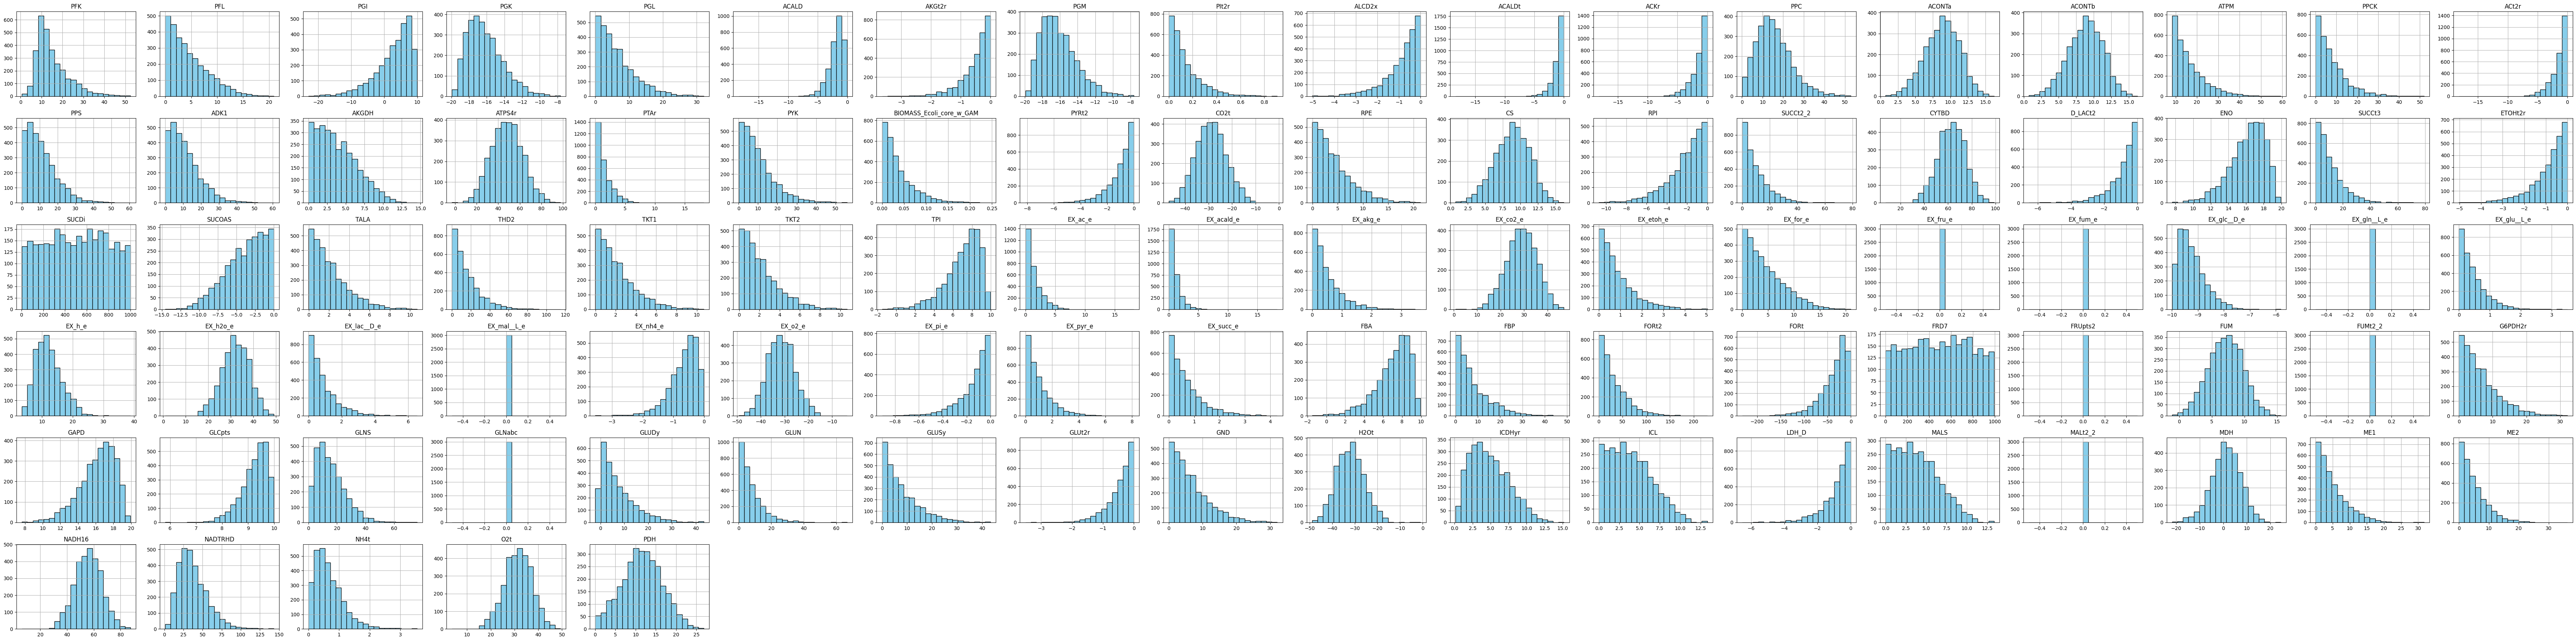

In [8]:

plot_grid_95_reactions(samples_dingo_condition_1, ec_cobra_model, nrows=6, ncols=18)
plot_grid_95_reactions(samples_dingo_condition_2, ec_cobra_model, nrows=6, ncols=18)


plot_grid_95_reactions(samples_optgp_condition_1, ec_cobra_model, nrows=6, ncols=18)
plot_grid_95_reactions(samples_optgp_condition_2, ec_cobra_model, nrows=6, ncols=18)


### Print statistics for reaction of interest

In [8]:

mean, min, max, std, skewness, kurtosis = sampling_statistics(samples_dingo_condition_1, 
                                                              reactions_ids_list=ec_dingo_reactions,
                                                              reaction_id="FRD7")
print(mean, min, max, std, skewness, kurtosis)

mean, min, max, std, skewness, kurtosis = sampling_statistics(samples_optgp_condition_1,
                                                              reactions_ids_list=ec_dingo_reactions,
                                                              reaction_id="FRD7")
print(mean, min, max, std, skewness, kurtosis)


392.39718232497586 3.0455410846985352e-06 994.495377899168 325.2446595501381 0.2637360057841765 -1.3148432369267957
472.6718014170746 0.382304192353347 994.6562905115869 286.6097116135265 0.10790284799447743 -1.1744436799719868
